In [22]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [23]:
# Inlezen van CSV-bestand
dataPositions = pd.read_csv('../data/positions_xyz_128px_full.csv')
dataCoordinates = pd.read_csv('../data/red_ball_coordinates_128px_full.csv')
dataPositions.shape, dataCoordinates.shape

((22398, 3), (22398, 14))

In [24]:
combined = pd.concat([dataCoordinates, dataPositions], axis=1)
combined = combined.dropna(thresh=combined.shape[1]-5)
combined

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6,x,y,z
0,NaN,NaN,45.038462,83.307692,86.925926,39.333333,0.333333,41.500000,NaN,NaN,88.136364,82.727273,68.5,118.50,10.138330,3.169981,15.09998
1,NaN,NaN,43.350000,83.850000,87.000000,40.111111,0.444444,42.555556,NaN,NaN,89.500000,84.500000,68.5,118.50,10.133340,3.269852,15.19985
2,NaN,NaN,43.791667,84.666667,87.310345,41.034483,0.444444,43.444444,NaN,NaN,89.473684,85.631579,68.5,118.50,10.125010,3.369500,15.29950
3,NaN,NaN,43.411765,85.705882,87.400000,41.400000,0.666667,44.500000,NaN,NaN,89.777778,86.500000,68.5,118.50,10.113370,3.468816,15.39882
4,NaN,NaN,44.000000,86.285714,87.740741,42.000000,1.062500,45.437500,NaN,NaN,89.944444,87.222222,68.5,118.50,10.098430,3.567688,15.49769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22393,85.192308,10.692308,56.400000,24.200000,83.500000,54.000000,11.888889,72.222222,60.5,70.833333,73.772727,98.000000,69.0,119.25,2.227737,0.208745,15.00000
22394,88.464286,6.535714,59.666667,39.500000,83.500000,54.000000,11.875000,71.750000,60.5,70.833333,73.619048,98.000000,69.0,119.25,2.230873,0.240388,15.00000
22395,88.407407,6.814815,59.666667,39.500000,83.500000,54.222222,11.500000,71.750000,60.5,70.833333,73.631579,98.210526,69.0,119.25,2.234063,0.275175,15.00000
22396,88.214286,7.321429,59.666667,39.500000,83.500000,54.500000,11.500000,71.750000,60.5,70.833333,73.647059,98.470588,69.0,119.25,2.237308,0.313067,15.00000


In [25]:
X = combined.iloc[:, :14]
y = combined.iloc[:, 14:]

In [26]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
dfX = imputer.fit_transform(X)

In [27]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(dfX, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

X_train_scaled.shape[0], X_val_scaled.shape[0], X_test_scaled.shape[0]

(11799, 2950, 3688)

In [28]:
model = MLPRegressor(hidden_layer_sizes=(100, ), max_iter=28000, random_state=42)

model.fit(X_train_scaled, y_train_scaled)

MLPRegressor(max_iter=28000, random_state=42)

In [29]:
y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)

In [30]:
from utils.evaluate import evaluate_model

mse_val, mae_val, r2_val = evaluate_model(y_val, y_val_pred, "Validation")

Mean Squared Error on Validation Set: 2.610000265661776
Mean Absolute Error on Validation Set: 0.923652358660037
R2 Score on Validation set: 0.8615064842973704


In [31]:
y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

In [32]:
mse_test, mae_test, r2_test = evaluate_model(y_test, y_test_pred, "Test")

Mean Squared Error on Test Set: 2.7426086761160104
Mean Absolute Error on Test Set: 0.945282053079224
R2 Score on Test set: 0.8543229581147971


In [33]:
y_test.shape, y_test_pred.shape

((3688, 3), (3688, 3))

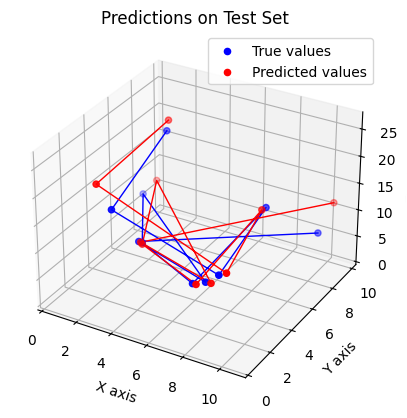

In [34]:
from utils.plot_maker_gaussian_process import plot_maker_3d

plot_maker_3d(np.array(y_test)[:10], np.array(y_test_pred)[:10], "Predictions on Test Set")

# Make Predictions on new data

In [35]:
test_data = pd.read_csv('../test-data/red_ball_coordinates_128px_2024-02-27_11h29m.csv', delimiter=',', decimal='.')
test_result = pd.read_csv('../test-data/positions_xyz_2024-02-27_11h29m.csv', delimiter=',', decimal='.')

In [36]:
new_combined = pd.concat([test_data, test_result], axis=1)
#new_combined = new_combined.dropna(thresh=new_combined.shape[1]-5)

In [37]:
new_X = new_combined.iloc[:, :14]
new_y = new_combined.iloc[:, 14:]
new_X.shape, new_y.shape

((505, 14), (505, 3))

In [38]:
new_X_imputed = imputer.transform(new_X)

new_X_scaled = scaler_X.transform(new_X_imputed)
new_y_scaled = scaler_y.transform(new_y)

In [39]:
new_y_pred_scaled = model.predict(new_X_scaled)

In [40]:
new_y_pred = scaler_y.inverse_transform(new_y_pred_scaled)

In [41]:
new_mse, new_mae, new_r2 = evaluate_model(new_y, new_y_pred, "New Data")

Mean Squared Error on New Data Set: 1.875984992969837
Mean Absolute Error on New Data Set: 0.6413052838837013
R2 Score on New Data set: 0.562595615763762


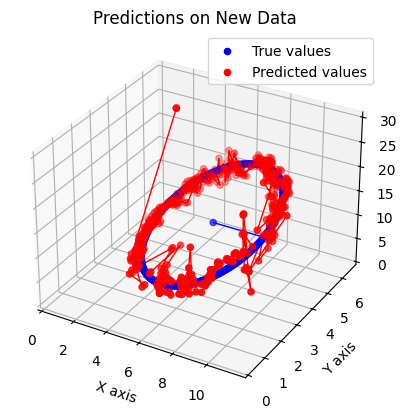

In [44]:
plot_maker_3d(np.array(new_y), np.array(new_y_pred), "Predictions on New Data")